August 19, 2020 Yuri Kobayashi <br/>
For Qiskit Training Session <br/>

# 1. ドイチ・ジョザアルゴリズム
# 3量子ビットでドイチ・ジョザアルゴリズムを実装する <a id='implementation'></a>

ドイチ・ジョザアルゴリズムを3量子ビットで実装してみましょう。一定(constant)な関数と均等（balanced)な関数をそれぞれつくります。

In [1]:
# 必要なライブラリのインポート
from qiskit import IBMQ, BasicAer, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute
import numpy as np

# 描画ツールのインポート
from qiskit.visualization import plot_histogram

In [2]:
#qiskitのversion確認
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}

In [3]:
#入力用量子ビットの数を設定
n = 3

## 1.1 均等な関数 <a id='balanced_function'></a>

均等な関数とは、0が出力される回数と1が出力される回数が同じであることを意味しました。<br/>

出力が０または１となる回数が半々となる量子回路はCNOTを使ってつくることができます。
<img src="images/deutsch_balanced1.jpg" style="width: 420px;"/>

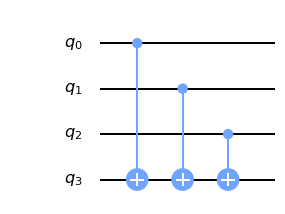

In [15]:
#上記の図のとおり4量子ビット回路を用意してください。
#各入力用量子ビットを制御に、出力用量子ビットを標的としたCNOT回路を作成してください。
q = QuantumCircuit(4)    # 4量子ビット回路を用意

q.cx(0,3)
q.cx(1,3)
q.cx(2,3)

q.draw(output="mpl")    # 回路を描画

## 演習１
出力ビットが0を返すときと1を返すときの入力について考えてみましょう。
上記回路に入力|𝑞2𝑞1𝑞0⟩=|000⟩, |001⟩, |010⟩, |011⟩, |100⟩, |101⟩, |110⟩, |111⟩をそれぞれ与えたとき、<br>
出力ビットが0を返す（|𝑞3⟩=0となる）場合、出力ビットが1を返す（|𝑞3⟩=1となる）場合の入力（|𝑞2𝑞1𝑞0⟩）をそれぞれ書き出してみましょう。<br>

| 出力 0を返す場合 | 出力 1を返す場合 |
|:---:     |:---:    |
|        |       |
|        |       |
|        |       |
|        |       |

結果は以下のテーブルにあるように、出力0を返す入力と、出力1を返す入力が半々（均等）になることがわかります。

| 出力 0を返す場合 | 出力 1を返す場合 |
|:---:     |:---:    |
| 000       |  001   |
| 011       |  010   |
| 101       |  100   |
| 110       |  111   |

入力のパターンを変えても出力が半々となるかどうかをみてみましょう。<br>
特定の制御ビットをXゲートで挟むことで、入力を変化させることができます。
![other_balanced_circuit](images/deutsch_balanced2.svg)

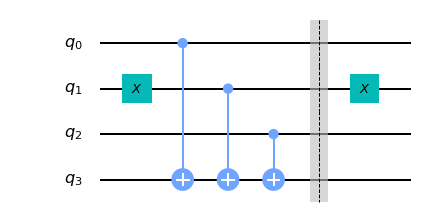

In [20]:
#　上記回路にあるように入力|𝑞2𝑞1𝑞0⟩=|010⟩をつくって|𝑞3⟩の状態を確認してください。

q = QuantumCircuit(4)    # 4量子ビット回路を用意

q.x(1)   # Xゲートを1番目の量子ビットに操作します。

q.cx(0,3)
q.cx(1,3)
q.cx(2,3)

q.barrier() # 回路をみやすくするためにバリアを配置

q.x(1)   # 最後にXゲートで1番目の量子ビットを挟みます。 

q.draw(output="mpl")    # 回路を描画

## 演習 2
上記回路に入力|𝑞2𝑞1𝑞0⟩=|000⟩, |001⟩, |010⟩, |011⟩, |100⟩, |101⟩, |110⟩, |111⟩をそれぞれ与えたとき、<br>
出力ビットが0を返す（|𝑞3⟩=0となる）場合、出力ビットが1を返す（|𝑞3⟩=1となる）場合の入力（|𝑞2𝑞1𝑞0⟩）をそれぞれ書き出してみましょう。<br>

| 出力が0となる場合 | 出力が1となる場合 |
|:---:     |:---:    |
|        |       |
|        |       |
|        |       |
|        |       |

結果は、以下のテーブルの通りです。演習１の出力と見比べてみましょう。<br>
それぞれの出力結果が得られる組合せは反転しつつ、場合の数は半々（均等）に保てていることがわかります。<br>

| 出力が0となる場合 | 出力が1となる場合 |
|:---------:|:---------:|
|    001    |    000    |
|    010    |    011    |
|    100    |    101    |
|    111    |    110    |

### 均等な関数の作成

前述のとおり、入力を制御ビットに、出力を標的ビットにCNOTゲートをかけることで均等な関数がつくれることがわかりました。さらに、特定の制御ビットをXゲートで挟むことで出力0または1を返す入力を変化させることができます。どの制御ビットを挟むべきかを確定してくれるよう、nの長さのバイナリ列 `b_str` を選んでみましょう。

In [21]:
balanced_f = QuantumCircuit(n+1,n)

In [22]:
b_str = "101"

任意のb_strはXゲートを置く場所を決める「鍵」として使うことができます。`b_str` の桁が`1` の時はXゲートを配置し、`0`のときは何もしません。コードでは以下のように書けます。

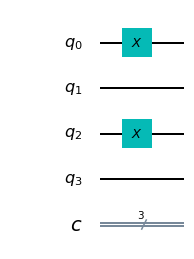

In [23]:
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_f.x(qubit)
balanced_f.draw()

つついて、CNOTを各量子ビットに配置します。

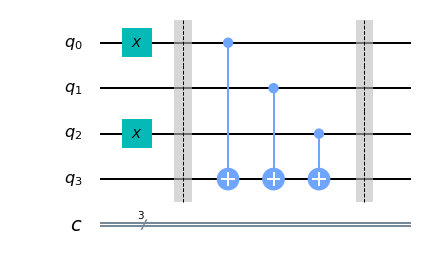

In [24]:
balanced_f.barrier()   #回路をみやすくするためにバリアを配置

for qubit in range(n):    #入力用量子ビットにCNOTゲートを適用
    balanced_f.cx(qubit, n)

balanced_f.barrier() #回路をみやすくするためにバリアを配置
balanced_f.draw()

最後に該当する制御量子ビットをＸゲートで挟みます。

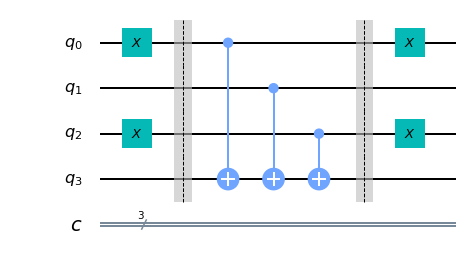

In [25]:
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_f.x(qubit)
        
balanced_f.draw()

均等な関数の完成です。つづいて、ドイチ・ジョザアルゴリズムのなかに、これらの関数を組み込んでいきましょう。

## 1.2 アルゴリズムへの均等な関数の実装 <a id='full_alg'></a>

ドイチ・ジョザアルゴリズムは以下の４つのステップで実装ができます。
1. 入力用の量子ビットをすべて$\vert0\rangle$に、そして最後の補助の量子ビット（アンシラ）だけ$\vert1\rangle$に初期化する
2. 全体にアダマールをかけて、入力用量子ビットはすべて$|{+}\rangle$ に、そして補助の量子ビットは$|{-}\rangle$にする
3. 制御ユニタリ　Uf |𝑥⟩|𝑦⟩↦|𝑥⟩|𝑓(𝑥)⊕𝑦⟩   を適用する
4. 最後に入力用の量子ビットに再びアダマールを適用する

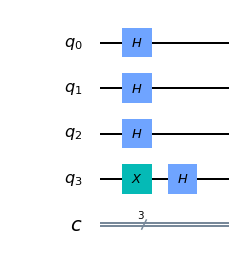

In [26]:
#ドイチ・ジョザアルゴリズムに均等な関数を実装した回路を"balanced_dj"と名付ける
balanced_dj = QuantumCircuit(n+1, n)

#Step 1:　各量子ビットはもともと|0>に初期化されているため、最後のアンシラだけ|1>に
balanced_dj.x(n) #Xゲートを最後のアンシラに適用

#Step 2: 全体にアダマールをかけて入力用量子ビットはすべて|+⟩ に、そして補助の量子ビットは|−⟩に
for qubit in range(n):    #全量子ビットにアダマールを適用
    balanced_dj.h(qubit)

#Step 3: オラクルUf |𝑥⟩|𝑦⟩↦|𝑥⟩|𝑓(𝑥)⊕𝑦⟩を適用
# 次ステップでUfを構築します

#Step 4: 最後の補助量子ビットにアダマールを適用して回路を描画
balanced_dj.h(n)    
balanced_dj.draw()

つぎに、前に構築した「均等な関数」を追加します。

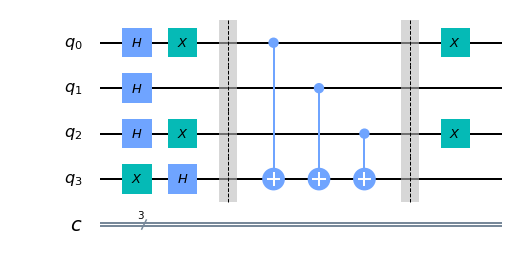

In [27]:
balanced_dj += balanced_f  #均等な関数の追加
balanced_dj.draw()

最後に、入力用量子ビット全体に再びアダマール（Ｈゲート）をかけて測定を行います。

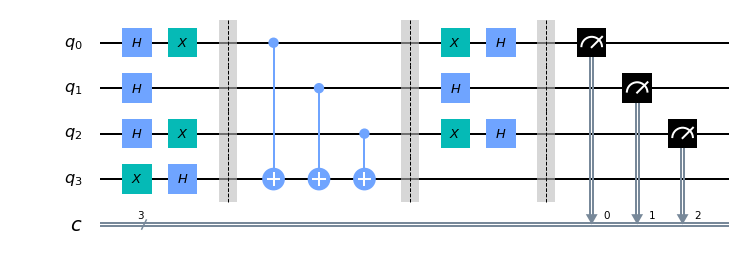

In [28]:
for qubit in range(n):
    balanced_dj.h(qubit)
balanced_dj.barrier()
for i in range(n):
    balanced_dj.measure(i, i)

balanced_dj.draw()

## 1.3 シミュレーターでの実行

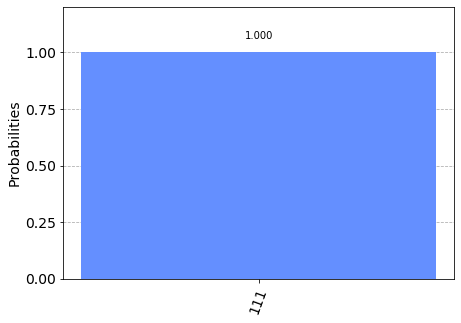

In [29]:
# 回路をシミュレーターに投げて結果を出力します
simulator = Aer.get_backend('qasm_simulator')
result = execute(balanced_dj, backend=simulator, shots=1).result()

# 結果をヒストグラムでプロットします
plot_histogram(result.get_counts(balanced_dj))

上記結果より、100%の確率で`111`を観測しました。均等な関数が正しく実装されたことがわかります。 

## 1.4 実機での実行 <a id='device'></a>

さきほどの回路を、今度は一番ジョブの空いている実機を指定して実行してみましょう。

In [30]:
# 初めて実デバイスで実行する人はこちらを実行
# from qiskit import IBMQ
# IBMQ.save_account('MY_API_TOKEN')    # ご自分のトークンを入れてください

configrc.store_credentials:WARNING:2020-08-15 21:05:38,464: Credentials already present. Set overwrite=True to overwrite.


In [32]:
#IBM Q accountをロードしプロバイダを指定
IBMQ.load_account()
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
#一番空いているバックエンドを自動的に選択して実行
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2020-08-15 21:06:11,179: Credentials are already in use. The existing account in the session will be replaced.
ibmqfactory.load_account:WARNING:2020-08-15 21:06:15,906: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_ourense


In [19]:
#上記で特定したバックエンドを指定してジョブを実行します。 
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(balanced_dj, backend=backend, shots=shots, optimization_level=3)

#プログラムの実行ステータスをモニターします。
job_monitor(job, interval = 2)

Job Status: job has successfully run


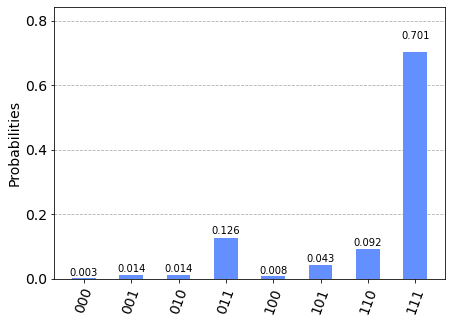

In [20]:
#計算結果(results)を取得し、答え（answer)をプロットします。
results = job.result()
answer = results.get_counts()

# 結果をヒストグラムでプロットします
plot_histogram(answer)

実機での実行結果でも `111`を最も高い確率で測定できました。`111`以外の答えも出ているのは、実機におけるノイズの影響です。

## 1.6 参考文献 <a id='references'></a>

1. David Deutsch and Richard Jozsa (1992). "Rapid solutions of problems by quantum computation". Proceedings of the Royal Society of London A. 439: 553–558.  [doi:10.1098/rspa.1992.0167](https://doi.org/10.1098%2Frspa.1992.0167).
2. R. Cleve; A. Ekert; C. Macchiavello; M. Mosca (1998). "Quantum algorithms revisited". Proceedings of the Royal Society of London A. 454: 339–354. [doi:10.1098/rspa.1998.0164](https://doi.org/10.1098%2Frspa.1998.0164).

# 2. ベルンシュタイン・ヴァジラニアルゴリズム

5つのステップでベルンシュタイン・ヴァジラニアルゴリズムをQiskitをつかって実装しましょう。

1. 秘密のバイナリ文字列を設定して、必要数の量子ビットを準備する。
2. 入力用のn個の量子ビットをすべて$\vert0\rangle$に、そして最後の補助の量子ビット（アンシラ）だけ$\vert1\rangle$に初期化する。Qiskitでは量子ビットはもともと$\vert0\rangle$に勝機されているため、$n$量子ビットに対しては何もせず、最後の補助用量子ビット（アンシラ）だけ $\vert1\rangle$にします。
3. 全体にアダマールをかけて、入力用量子ビットはすべて$|{+}\rangle$ に、そして補助の量子ビットは$|{-}\rangle$にする

4. 秘密のバイナリ文字列を保持する箱（オラクル）を作成する。 $s.x$ modulo 2を計算する関数を作成するために最初の$n$量子ビットのなかに$1$が含まれているときに$CX$ゲートを適用するようにする。例えば秘密のバイナリ文字列の最初のビットが1のときは$CX$ゲートを$n$番目の量子ビットに適用する。

5. 最後にアダマールを入力n量子ビットにかけて測定する。

In [10]:
#必要に応じてQiskitのライブラリ等のインポート
%matplotlib inline
from qiskit import *
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.visualization import plot_histogram

In [11]:
#適当なバイナリ文字列を設定
s = '011001'

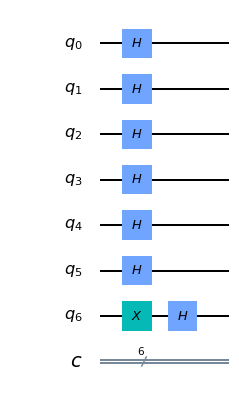

In [12]:
#qcという名の量子回路を準備
qc = QuantumCircuit(6+1,6)
qc.x(6)
qc.h(6)
qc.h(range(6))
qc.draw()

## 2.1 秘密の数と量子ビットの数を設定する

In [13]:
# Step 1
s = '011001'
#$n+1$ 量子ビットと結果を格納する $n$個の古典レジスタを用意する。$n$は秘密の文字列の長さと同じ。
n = len(s)
qc = QuantumCircuit(n+1,n)

## 2.2 回路を作成する

In [14]:
# Step 2

qc.x(n) #最後の量子ビットを|1⟩にする

qc.barrier() #回路をみやすくするためにバリアを配置

# Step 3

qc.h(range(n+1)) #全体にHゲートを適用

qc.barrier() #回路をみやすくするためにバリアを配置

# Step 4

for ii, yesno in enumerate(reversed(s)):
    if yesno == '1': 
        qc.cx(ii, n)
    
qc.barrier() #回路をみやすくするためにバリアを配置

# Step 5

qc.h(range(n+1)) #全量子ビットに再びHを適用

qc.barrier() #回路をみやすくするためにバリアを配置

qc.measure(range(n), range(n)) # 0 から n-1までの入力n量子ビットを測定し古典レジスタに結果を格納

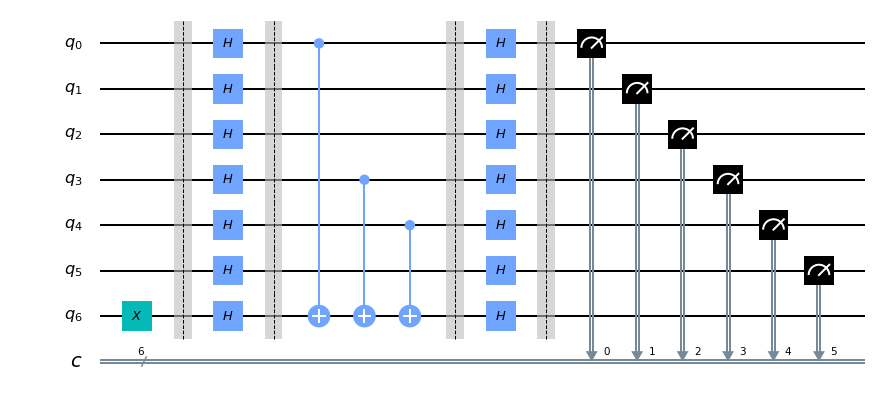

In [15]:
%matplotlib inline
#回路図を描画
qc.draw(output='mpl')

## 2.3 シミュレーターでの実行
さきほどの回路を、今度は一番ジョブの空いている実機を指定して実行してみましょう。

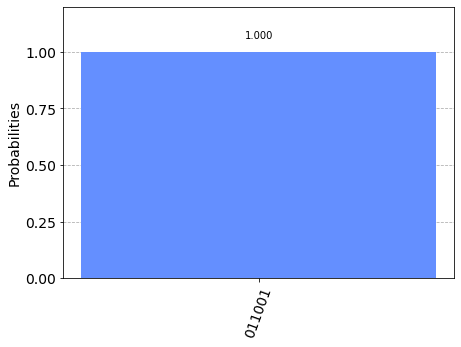

In [16]:
# 回路をシミュレーターに投げて結果を出力します
simulator = Aer.get_backend('qasm_simulator')
# shots=1で実施
result = execute(qc, backend=simulator, shots=1).result()
# 結果をヒストグラムでプロットします
from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts(qc))

## 2.4 実機での実行

In [19]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_16_melbourne


In [20]:
#上記で特定したバックエンドを指定してジョブを実行します。 
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(qc, backend=backend, shots=shots, optimization_level=3)

#プログラムの実行ステータスをモニターします。
job_monitor(job, interval = 2)

Job Status: job has successfully run


In [28]:
# filter = {'hubInfo.hub.name': 'ibm-q'}
# job_list = backend.jobs(limit=5, db_filter=filter)
job_list = backend.jobs()[0]
print(job_list)

IBMQJob(_api=<qiskit.providers.ibmq.api.clients.account.AccountClient object at 0x7fe421d9e940>, _api_status='COMPLETED', _backend=<IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>, _backend_info={'id': '5ba502d0986f16003ea56c87', 'name': 'ibmq_16_melbourne'}, _cancelled=False, _creation_date=datetime.datetime(2020, 7, 11, 12, 24, 20, 100000, tzinfo=tzutc()), _error=None, _job_error_msg=None, _job_id='5f09af74061697001ab44285', _kind=<ApiJobKind.QOBJECT_STORAGE: 'q-object-external-storage'>, _name=None, _qobj=None, _queue_info=None, _result=None, _run_mode='fairshare', _status=<JobStatus.DONE: 'job has successfully run'>, _tags=[], _time_per_step=None, _use_object_storage=True, end_date='2020-07-11T12:27:53.365Z', hub_info={'hub': {'name': 'ibm-q'}, 'group': {'name': 'open'}, 'project': {'name': 'main'}}, share_level='none', user_id='5c1b0358748e79005348b8f4')


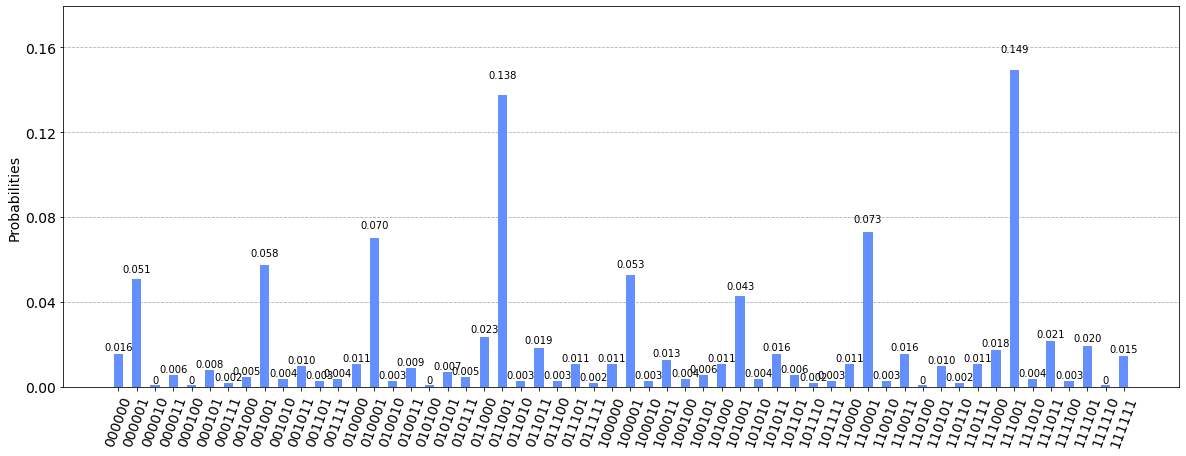

In [33]:
#計算結果(results)を取得し、答え（answer)をプロットします。
results = job.result()
answer = results.get_counts()
# 結果をヒストグラムでプロットします
plot_histogram(answer,figsize=(20,7))

実機での実行結果でも秘密のバイナリ文字列を特定できました。実機におけるノイズの影響も確認できます。

## 2.4 参考文献

#### Journal Papers

1. Ethan Bernstein and Umesh Vazirani (1997) "Quantum Complexity Theory" SIAM Journal on Computing, Vol. 26, No. 5: 1411-1473, <a id='1' href='https://doi.org/10.1137/S0097539796300921'>doi:10.1137/S0097539796300921</a>).

#### Tutorials
For detailed information about Qiskit, check out the tutorials in the Github repository:

https://github.com/Qiskit/qiskit-iqx-tutorials

For details on the Bernstein-Vazirani algorithm, check out the open-source `Learn Quantum Computation using Qiskit` textbook:

https://community.qiskit.org/textbook/